# Conformalized Quantile LGBM regressor for Anomaly detection

Based on: https://proceedings.neurips.cc/paper_files/paper/2019/file/5103c3584b063c431bd1268e9b5e76fb-Paper.pdf

In [1]:
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm  # progress bar
import os
from pathlib import Path
root_dir = Path(os.getcwd()).resolve().parent
os.chdir(root_dir)
print(os.getcwd())
from utils.data_preparation import preprocess_data, split_data_validation, mapping
import optuna
from optuna.samplers import TPESampler
plt.style.use('seaborn-v0_8-ticks')
sns.set_theme(style="ticks")
np.random.seed(42)

C:\Users\xkorpijo3\OneDrive - Fortum\Desktop\Master-thesis-GBRT-dam


## A. Data Loading and Preparation

In [2]:
features = ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18',
            'h', 'h_MA_007', 'h_MA_014', 'h_MA_030', 'h_MA_060', 'h_RC_007', 'h_RC_030',
            'P', 'P_RS_030', 'P_RS_060', 'P_RS_090', 'P_RS_180',
            'T', 'T_MA_001', 'T_MA_007', 'T_MA_030', 'T_MA_060',
            't', 'ln_t', 'Cos_s', 'Sin_s', 'Cos_2s', 'Sin_2s', 'month', 'year']
target = 'GV51'
if target in features:
    features.remove(target)
poly_degree = 4
start_date = "08-01-2020"
end_date = "03-01-2025"
validation_size = 0.1
test_size = 0.2

X, y, dates = preprocess_data(features, target, start_date, end_date, poly_degree=poly_degree, \
                               test_size=test_size, validation_size=validation_size)
    
X_train, X_val, X_test, y_train, y_val, y_test, split_idx_validation, split_idx_test = split_data_validation(X, y, test_size=test_size)
print(f"Split index val: {split_idx_validation}")
print(f"Split index test: {split_idx_test}")
print(f"Training set size: {len(X_train)} (h)")
print(f"Validation set size: {len(X_val)} (h)")
print(f"Test set size: {len(X_test)} (h)")
print(f"Dataset length: {len(X)}")

Split index val: 24091
Split index test: 32122
Training set size: 24091 (h)
Validation set size: 8031 (h)
Test set size: 8031 (h)
Dataset length: 40153


In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24091 entries, 0 to 24090
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sin_s     24091 non-null  float64
 1   Cos_s     24091 non-null  float64
 2   Sin_2s    24091 non-null  float64
 3   Cos_2s    24091 non-null  float64
 4   t         24091 non-null  int64  
 5   ln_t      24091 non-null  float64
 6   month     24091 non-null  int32  
 7   year      24091 non-null  int32  
 8   GV1       24091 non-null  float64
 9   GV3       24091 non-null  float64
 10  MB4       24091 non-null  float64
 11  MB8       24091 non-null  float64
 12  MB10      24091 non-null  float64
 13  MB18      24091 non-null  float64
 14  h         24091 non-null  float64
 15  h_MA_007  24091 non-null  float64
 16  h_MA_014  24091 non-null  float64
 17  h_MA_030  24091 non-null  float64
 18  h_MA_060  24091 non-null  float64
 19  h_RC_007  23923 non-null  float64
 20  h_RC_030  23371 non-null  fl

# B. Modeling + Tuning

In [17]:
quantile_mapping = {
    95: ['0.025', '0.975'],
    90: ['0.05', '0.95'],
    80: ['0.10', '0.90'],
}

In [18]:
quantiles = [0.025, 0.05, 0.10, 0.5, 0.90, 0.95, 0.975]
levels = np.array([95, 90, 80, 50])
quantile_str = str(quantiles).replace('[','').replace(']','')

In [19]:
GV3_params = {
        'n_estimators': 2133, 
        'learning_rate': 0.08, 
        'max_depth': 11, 
        'num_leaves': 27, 
        'subsample': 0.69, 
        'feature_fraction': 0.78, 
        'min_gain_to_split': 10.69, 
        'reg_alpha': 1.85, 
        'reg_lambda': 1.05, 
        'linear_tree': False
}

GV51_params = {
        'n_estimators': 852, 
        'learning_rate': 0.08, 
        'max_depth': 7, 
        'num_leaves': 17, 
        'subsample': 0.66, 
        'feature_fraction': 0.78, 
        'min_gain_to_split': 2.04, 
        'reg_alpha': 2.89, 
        'reg_lambda': 0.7, 
        'linear_tree': False
    }

In [20]:
quantile_models = {} 
predict_val = {}
predict_test = {}

for i in range(len(quantiles)):
    print('prediction of quantile', quantiles[i])
    lgb = LGBMRegressor(objective='quantile', 
                        metric='quantile',
                        alpha=quantiles[i], 
                        n_jobs=-1, 
                        verbose=-1,
                        **GV51_params)
    
    lgb.fit(X_train, y_train, eval_set=(X_val, y_val))

    predict_val[quantiles[i]] = lgb.predict(X_val)
    predict_test[quantiles[i]] = lgb.predict(X_test)

    # Store in dictionary with quantile as key
    quantile_models[quantiles[i]] = lgb

prediction of quantile 0.025
prediction of quantile 0.05
prediction of quantile 0.1
prediction of quantile 0.5
prediction of quantile 0.9
prediction of quantile 0.95
prediction of quantile 0.975


Text(0, 0.5, 'GV51')

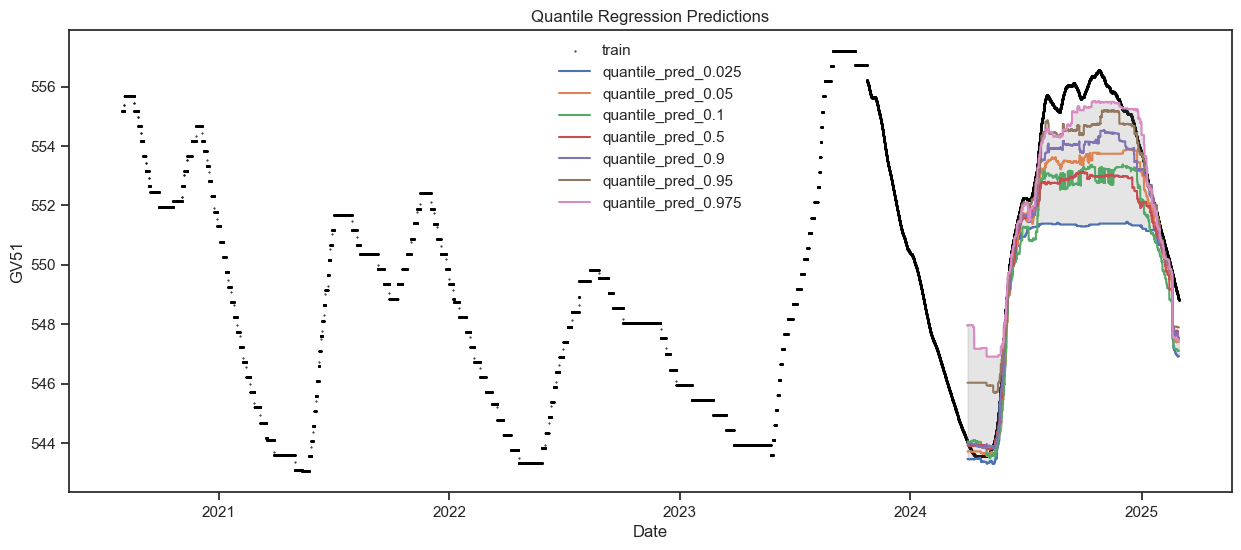

In [26]:
plt.figure(figsize=[15, 6])

# Plot the original data points
plt.scatter(dates, y, label='train', s=.2, color='black')

# Plot each quantile prediction
for quantile in quantiles:
    plt.plot(dates[split_idx_test:], predict_test[quantile], 
             label=f'quantile_pred_{quantile}')

# If you want to shade between upper and lower quantiles (assuming quantiles contains values like 0.05 and 0.95)
if len(quantiles) >= 2:
    # Sort quantiles to identify lower and upper bounds
    sorted_quantiles = sorted(quantiles)
    lower_quantile = sorted_quantiles[0]
    upper_quantile = sorted_quantiles[-1]
    
    # Fill between the lower and upper quantile predictions
    plt.fill_between(dates[split_idx_test:], 
                     predict_test[lower_quantile], 
                     predict_test[upper_quantile], 
                     color='gray', alpha=0.2)
                    #  label=f'Confidence Interval ({lower_quantile}-{upper_quantile})')

plt.legend()
plt.title('Quantile Regression Predictions')
plt.xlabel('Date')
plt.ylabel(target)

Text(0, 0.5, 'GV51')

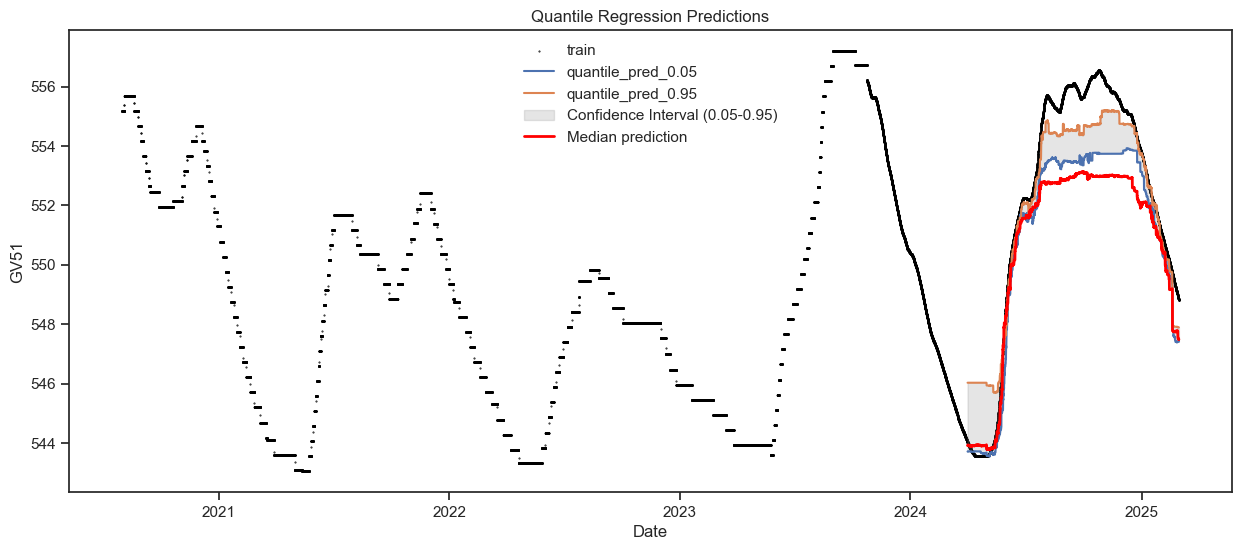

In [23]:
plt.figure(figsize=[15, 6])

# Plot the original data points
plt.scatter(dates, y, label='train', s=.2, color='black')

# Filter to include only specific quantiles
selected_quantiles = [0.05, 0.95]

# Plot only the selected quantiles
for quantile in selected_quantiles:
    if quantile in quantiles:  # Make sure the quantile exists in your dictionary
        plt.plot(dates[split_idx_test:], predict_test[quantile], 
                 label=f'quantile_pred_{quantile}')

# Shade between the upper and lower quantiles
if all(q in quantiles for q in selected_quantiles):
    plt.fill_between(dates[split_idx_test:], 
                     predict_test[selected_quantiles[0]], 
                     predict_test[selected_quantiles[1]], 
                     color='gray', alpha=0.2, 
                     label=f'Confidence Interval ({selected_quantiles[0]}-{selected_quantiles[1]})')

# If you want to include the median prediction as well
if 0.5 in quantiles:
    plt.plot(dates[split_idx_test:], predict_test[0.5], 
             color='red', linestyle='-', linewidth=2,
             label='Median prediction')

plt.legend()
plt.title('Quantile Regression Predictions')
plt.xlabel('Date')
plt.ylabel(target)

## Test 2

In [37]:
def coverage_fraction(y, upper, lower):
    """ 
    Compute average coverage of prediction intervals
    """
    return np.mean(np.logical_and(y <= upper, y >= lower))

def pi_len(y, upper, lower):
    """
    Compute normalized length of prediction intervals
    """
    avg_length = np.mean(np.abs(upper - lower))
    y_range = np.max(y) - np.min(y)
    
    # Avoid division by zero
    if y_range == 0:
        return avg_length 

    return avg_length / y_range

def objective_lgb_quantiles(trial, X_train, y_train, X_val, y_val, alpha=0.05):
    """
    The objective function to tune hyperparameters. It evaluate the score on a
    validation set. This function is used by Optuna, a Bayesian tuning framework.
    """

    params = {
            'verbose': -1,
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
            'learning_rate': trial.suggest_float("learning_rate", 1e-5, 0.01, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'num_leaves': trial.suggest_int('num_leaves', 2, 30),
            'subsample': trial.suggest_float('subsample', 0.5, 1, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1, log=True),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-8, 15, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),               # L1 regularization term
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),             # L2 regularization term (similar to your 'l2_regularization')
            'linear_tree': trial.suggest_categorical('linear_tree', [True, False])
            }
    
    model_upper = LGBMRegressor(objective='quantile', 
                                    metric='quantile',
                                    alpha=1-alpha, 
                                    n_jobs=-1, 
                                    **params)
    
    model_lower = LGBMRegressor(objective='quantile', 
                                    metric='quantile',
                                    alpha=alpha, 
                                    n_jobs=-1, 
                                    **params)

    model_upper.fit(X_train, y_train, eval_set=(X_val, y_val))
    model_lower.fit(X_train, y_train, eval_set=(X_val, y_val))

    predict_val_upper = model_upper.predict(X_val)
    predict_val_lower = model_lower.predict(X_val)
    
    coverage = coverage_fraction(y_val, predict_val_upper, predict_val_lower)
    interval_length = pi_len(y, predict_val_upper, predict_val_lower)
    
    desired_coverage = 1 - 2*alpha  # For example, with alpha=0.05, desired coverage is 0.90
    
    # Create a balanced objective that:
    # 1. Penalizes coverage far from desired coverage
    # 2. Rewards narrower intervals when coverage is good
    coverage_penalty = abs(coverage - desired_coverage) * 10  # Scale factor to emphasize coverage matching
    
    # Combined objective: we want to minimize this value
    # When coverage is good, this mostly optimizes for interval_length
    # When coverage is off, the penalty dominates
    total_loss = interval_length + coverage_penalty

    del model_upper
    del model_lower
    return total_loss

In [38]:
def lgb_quantiles_tune(target, X_train, X_val, y_train, y_val):
    n_trials = 30
    alpha = 0.05
    # Uncomment to suppress optuna log messages
    # optuna.logging.set_verbosity(optuna.logging.WARNING)
    sampler = TPESampler(seed=42)
    study_model = optuna.create_study(direction = 'minimize', sampler = sampler, study_name=f'hyperparameters_tuning_{target}')
    study_model.optimize(lambda trial: objective_lgb_quantiles(trial, X_train, y_train, X_val, y_val, alpha), n_trials = n_trials)  # type: ignore

    trial = study_model.best_trial
    best_params = trial.params
    print('Best params from optuna: \n', best_params)
    del study_model
    return best_params

In [39]:
lgb_quantiles_tune(target, X_train, X_val, y_train, y_val)

[I 2025-04-03 15:11:09,271] A new study created in memory with name: hyperparameters_tuning_GV51
[I 2025-04-03 15:11:28,370] Trial 0 finished with value: 438.82228018314134 and parameters: {'n_estimators': 1749, 'learning_rate': 0.0071144760093434225, 'max_depth': 10, 'num_leaves': 19, 'subsample': 0.5571040234647635, 'feature_fraction': 0.25707833957860277, 'min_gain_to_split': 3.411776126198979e-08, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598, 'linear_tree': True}. Best is trial 0 with value: 438.82228018314134.
[I 2025-04-03 15:11:39,183] Trial 1 finished with value: 169.59788750632256 and parameters: {'n_estimators': 2940, 'learning_rate': 0.00314288089084011, 'max_depth': 5, 'num_leaves': 7, 'subsample': 0.5677802257385179, 'feature_fraction': 0.3263519391284684, 'min_gain_to_split': 0.0006534508172137992, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06, 'linear_tree': True}. Best is trial 1 with value: 169.59788750632256.
[I 2025-04-0

Best params from optuna: 
 {'n_estimators': 1932, 'learning_rate': 0.00016537057385716719, 'max_depth': 11, 'num_leaves': 21, 'subsample': 0.701657649876074, 'feature_fraction': 0.42077715125884596, 'min_gain_to_split': 0.0001249726469552462, 'reg_alpha': 0.8787907753352665, 'reg_lambda': 2.611456418570892, 'linear_tree': True}


{'n_estimators': 1932,
 'learning_rate': 0.00016537057385716719,
 'max_depth': 11,
 'num_leaves': 21,
 'subsample': 0.701657649876074,
 'feature_fraction': 0.42077715125884596,
 'min_gain_to_split': 0.0001249726469552462,
 'reg_alpha': 0.8787907753352665,
 'reg_lambda': 2.611456418570892,
 'linear_tree': True}

In [40]:
best_params = {'n_estimators': 1932,
 'learning_rate': 0.00016537057385716719,
 'max_depth': 11,
 'num_leaves': 21,
 'subsample': 0.701657649876074,
 'feature_fraction': 0.42077715125884596,
 'min_gain_to_split': 0.0001249726469552462,
 'reg_alpha': 0.8787907753352665,
 'reg_lambda': 2.611456418570892,
 'linear_tree': True}

In [41]:
alpha = 0.05

model_upper = LGBMRegressor(objective='quantile', 
                                    metric='quantile',
                                    alpha=1-alpha, 
                                    n_jobs=-1, 
                                    **best_params)
    
model_lower = LGBMRegressor(objective='quantile', 
                                    metric='quantile',
                                    alpha=alpha, 
                                    n_jobs=-1, 
                                    **best_params)

model_upper.fit(X_train, y_train, eval_set=(X_val, y_val))
model_lower.fit(X_train, y_train, eval_set=(X_val, y_val))

LGBMRegressor(alpha=0.05, feature_fraction=0.42077715125884596,
              learning_rate=0.00016537057385716719, linear_tree=True,
              max_depth=11, metric='quantile',
              min_gain_to_split=0.0001249726469552462, n_estimators=1932,
              n_jobs=-1, num_leaves=21, objective='quantile',
              reg_alpha=0.8787907753352665, reg_lambda=2.611456418570892,
              subsample=0.701657649876074)

In [43]:
y_test_upper = model_upper.predict(X_test)
y_test_lower = model_lower.predict(X_test)

<Figure size 640x480 with 0 Axes>

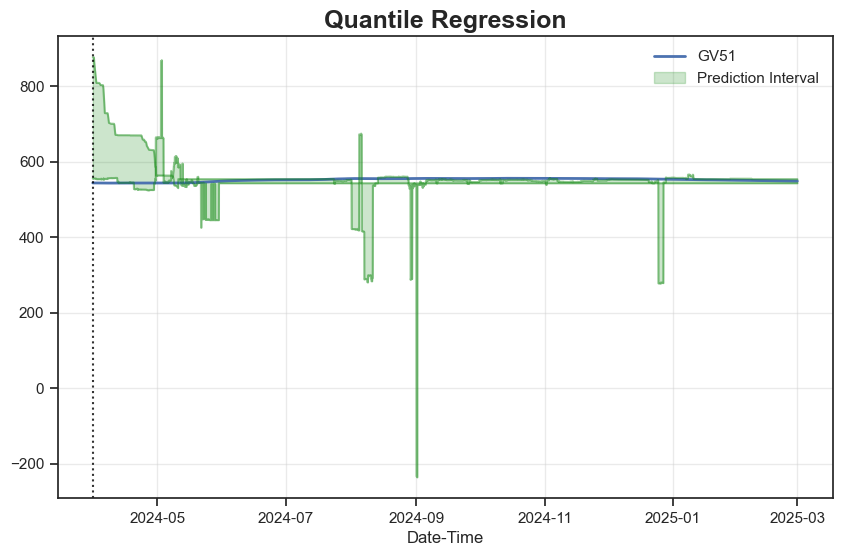

In [47]:
plt.clf()
plt.figure(figsize=(10, 6))

# Adding labels and title
plt.title('Quantile Regression', fontsize=18, fontweight='bold')
plt.plot(dates[split_idx_test:], y_test, label=target, linewidth=2)
plt.plot(dates[split_idx_test:], y_test_upper, color='green', alpha=0.4)
# plt.plot(dates[split_idx_test:], regressor_pred, color='red')
plt.plot(dates[split_idx_test:], y_test_lower, color='green', alpha=0.4)
# Add shading between upper and lower quantiles
plt.fill_between(dates[split_idx_test:], y_test_upper, y_test_lower, 
                 color='green', alpha=0.2, label='Prediction Interval')
plt.axvline(x=dates.iloc[split_idx_test], color='black', alpha=0.8, linestyle=':')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel('Date-Time')
plt.show()

In [ ]:
regressor.fit(X_train, y_train, eval_set=(X_val, y_val))
regressor_pred = regressor.predict(X_test)

In [ ]:
lower.fit(X_train, y_train)
lower_pred = lower.predict(X_test)

In [ ]:
upper.fit(X_train, y_train)
upper_pred = upper.predict(X_test)

In [ ]:
score = r2_score(y_test, regressor_pred)
print(score)

0.9963259189689131


<Figure size 640x480 with 0 Axes>

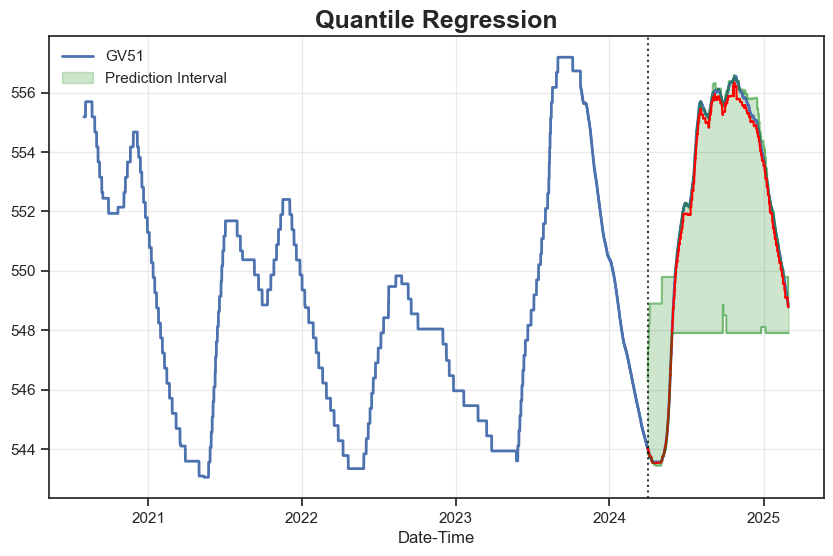

In [ ]:
plt.clf()
plt.figure(figsize=(10, 6))

# Adding labels and title
plt.title('Quantile Regression', fontsize=18, fontweight='bold')
plt.plot(dates, X_all[target], label=target, linewidth=2)
plt.plot(dates[split_index:], upper_pred, color='green', alpha=0.4)
plt.plot(dates[split_index:], regressor_pred, color='red')
plt.plot(dates[split_index:], lower_pred, color='green', alpha=0.4)
# Add shading between upper and lower quantiles
plt.fill_between(dates[split_index:], lower_pred, upper_pred, 
                 color='green', alpha=0.2, label='Prediction Interval')
plt.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel('Date-Time')
plt.show()

<Figure size 640x480 with 0 Axes>

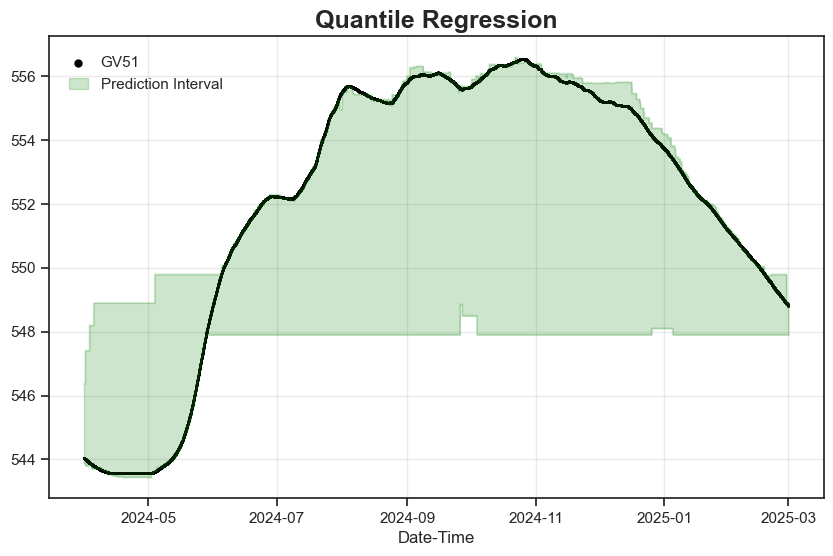

In [ ]:
# Plotting all precipitation data
plt.clf()
plt.figure(figsize=(10, 6))

# Adding labels and title
plt.title('Quantile Regression', fontsize=18, fontweight='bold')
plt.scatter(dates[split_index:], y_test, label=target, s=1, color='black')
plt.plot(dates[split_index:], upper_pred, color='green', alpha=0.1)
# plt.plot(dates[split_index:], regressor_pred, alpha=0.9, linewidth=0.9, linestyle='--', color='red', label='Median prediction')
plt.plot(dates[split_index:], lower_pred, color='green', alpha=0.1)
# Add shading between upper and lower quantiles
plt.fill_between(dates[split_index:], lower_pred, upper_pred, 
                 color='green', alpha=0.2, label='Prediction Interval')
# plt.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
plt.grid(alpha=0.4)
plt.legend(loc='upper left', markerscale=5, \
           columnspacing=1, handlelength=1.3, handletextpad=0.8, borderpad=0.8)
plt.xlabel('Date-Time')
plt.show()

In [ ]:
coverage_QR = coverage_fraction(y_test, upper_pred, lower_pred)

In [ ]:
print(f"Expected coverage: {1 - 2*alpha}")
print(f"Actual coverage: {coverage_QR}")

Expected coverage: 0.9
Actual coverage: 0.7565682978458473
